In [2]:
import pickle
from tqdm import tqdm
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
# Trace builiding code
class Trace:
    def __init__(self):
        self.calls = []

class Node_info:
    def __init__(self, num_id, n_type):
        self.num_id = num_id
        self.n_type = n_type

class Call:
    def __init__(self, traceid, timestamp, rpcid, um, dm, rpctype, interface, rt):
        self.traceid = traceid
        self.timestamp = timestamp
        self.rpcid = rpcid
        self.um = um
        self.dm = dm 
        self.rpctype = rpctype
        self.interface = interface
        self.rt = rt
    def string(self):
        return self.traceid + "," + str(self.timestamp) + "," + self.rpcid + "," + self.um + "," + self.dm + "," +\
            self.rpctype + "," + self.interface + "," + str(self.rt)

def csv_to_df(file: str):
    use_columns = list(range(9)) 
    df = pd.read_csv(file,delimiter=',', usecols=use_columns)
    return df

def extract_traceid_rows(df, tid):
    f_df = df[df['traceid'] == tid]
    tid_calls = [
        Call(
            str(row.traceid), 
            int(row.timestamp), 
            str(row.rpcid), 
            str(row.um), 
            str(row.dm), 
            str(row.rpctype), 
            str(row.interface), 
            int(row.rt)
        ) for row in f_df.itertuples(index=False)
    ]
    return tid_calls


def df_to_tracesdict(df):
    '''
    Args: Alibaba traces dataframe
    Return: Dict, Key:tid, Val:list of edges
    '''
    tids_list = df['traceid'].unique().tolist()
    traces_edges = {}
    for i in tqdm(range(len(tids_list))):
        tid_calls = extract_traceid_rows(df, tids_list[i])
        t_edges = [] # list of edges of trace
        for call in tid_calls:
            t_edges.append([call.um, call.dm])
        traces_edges[tids_list[i]] = t_edges
    return traces_edges

def df_rpcid_analysis(df):
    tids_list = df['traceid'].unique().tolist()
    no_inode_tids = []
    no_inode_tid_rpcid = {}
    for i in tqdm(range(len(tids_list))):
        tid_calls = extract_traceid_rows(df, tids_list[i])
        initial_node = ''
        for call in tid_calls:
            if call.rpcid == "0":
                initial_node = call.dm
        if initial_node == '':
            no_inode_tids.append(tids_list[i])
    for i in tqdm(range(len(no_inode_tids))):
        tid_calls = extract_traceid_rows(df, no_inode_tids[i])
        for call in tid_calls:
            if no_inode_tids[i] not in no_inode_tid_rpcid:
                no_inode_tid_rpcid[no_inode_tids[i]] = []
            no_inode_tid_rpcid[no_inode_tids[i]].append(call.rpcid)

    return no_inode_tid_rpcid

def build_digraph_from_tracesdict(traces_dict):

    full_graph_edge_list = []
    for edge_list in traces_dict.values():
        full_graph_edge_list.extend(edge_list)
    G = nx.DiGraph()
    G.add_edges_from(full_graph_edge_list)

    return G

def pkl_to_dict(file_path):
    with open(file_path, 'rb') as pkl_file:
        T_prime = pickle.load(pkl_file)
    return T_prime

def pkl_to_graph(exp_name):
    file_path = 'downsampled_graphs/' + exp_name + '.pkl'
    T_prime = pkl_to_dict(file_path)
    sampled_G = build_digraph_from_tracesdict(T_prime)

    return sampled_G

In [4]:
'''
Read & Build Original Graph
'''
df = csv_to_df("./casper_rebuild_cleaned.csv")

# Extract all tids
tids_list = df['traceid'].unique()
num_traces = len(tids_list)
print("Num of tids: ", num_traces)

# Building the full original digraph
T_original = df_to_tracesdict(df)
G_original = build_digraph_from_tracesdict(T_original)

print("Number of nodes:", G_original.number_of_nodes())

Num of tids:  10421


100%|██████████| 10421/10421 [02:38<00:00, 65.83it/s]


Number of nodes: 3656


In [4]:
'''
Read & Build Sampled graphs
'''
T_prime_500n_5000t = pkl_to_dict('downsampled_graphs/500nodes_5000traces.pkl')
T_prime_250n_5000t = pkl_to_dict('downsampled_graphs/250nodes_5000traces.pkl')

# Building the sampled original digraph
G_sampled_500 = build_digraph_from_tracesdict(T_prime_500n_5000t)
G_sampled_250 = build_digraph_from_tracesdict(T_prime_250n_5000t)
print("Number of nodes:", G_sampled_500.number_of_nodes())
print("Number of nodes:", G_sampled_250.number_of_nodes())

Number of nodes: 484
Number of nodes: 249


In [10]:
'''
In & Out degree distribution
'''

def deg_dist_viz(Gs_and_labels, in_or_out):
    '''
    Generates a CDF graph for in/out deg dist of graphs
    Args: Gs_and_label= [[G, label], [], ...],
          in_or_out= 'in' or 'out'
    '''
    for G, label in Gs_and_labels:
        if in_or_out == 'in':
            degrees = G.in_degree(G.nodes())
        elif in_or_out == 'out':
            degrees = G.out_degree(G.nodes())
        deg_dist = [tup[1] for tup in list(degrees)]
        x_vals = np.sort(deg_dist)
        y_vals = np.arange(len(deg_dist))/float(len(deg_dist))
        plt.plot(x_vals, y_vals, label=label)
    if in_or_out == "in":
        plt.xlabel('In-degree')
    if in_or_out == "out":
        plt.xlabel('Out-degree')
    plt.xscale('log')
    plt.ylabel('CDF')
    plt.legend()
    plt.tight_layout()
    # plt.show()

    plt.savefig('figs/outdeg_dist_500n_variedt.png')
    plt.close()
# Kolmogrov D Statistic

def deg_dist_viz_hist(Gs_and_labels, in_or_out):
    '''
    Generates a histogram for in/out deg dist of graphs
    Args: Gs_and_label= [[G, label], [], ...],
          in_or_out= 'in' or 'out'
    '''
    for G, label in Gs_and_labels:
        if in_or_out == 'in':
            degrees = G.in_degree(G.nodes())
        elif in_or_out == 'out':
            degrees = G.out_degree(G.nodes())
        deg_dist = [tup[1] for tup in list(degrees)]
        plt.hist(deg_dist,alpha=0.4, label=label)#bins=range(min(deg_dist), max(deg_dist) + 1)
    if in_or_out == "in":
        plt.xlabel('In-degree')
    elif in_or_out == "out":
        plt.xlabel('Out-degree')
        
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.show()

import numpy as np
from scipy.special import rel_entr

def calc_ks_stat():
    pass

In [ ]:
Original_indeg_dist = [tup[1] for tup in list(G_original.in_degree(G_original.nodes()))]
Original_outdeg_dist = [tup[1] for tup in list(G_original.out_degree(G_original.nodes()))]

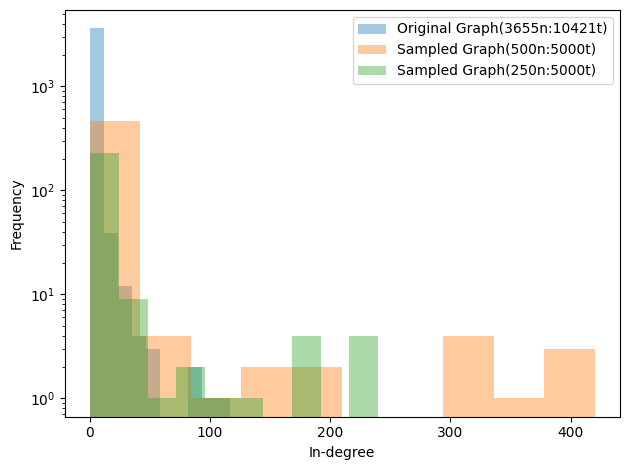

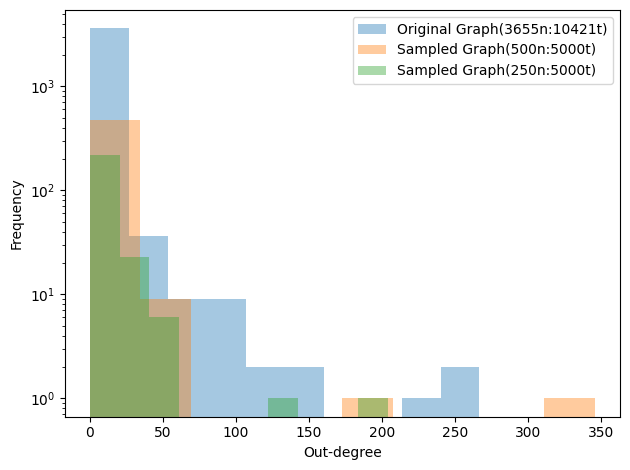

In [11]:
Gs_and_labels = [[G_original, 'Original Graph(3092n:4439t)'],[G_sampled_500, 'Sampled Graph(500n:5000t)'], \
                 [G_sampled_250, 'Sampled Graph(250n:5000t)']]
deg_dist_viz_hist(Gs_and_labels, 'in')
deg_dist_viz_hist(Gs_and_labels, 'out')

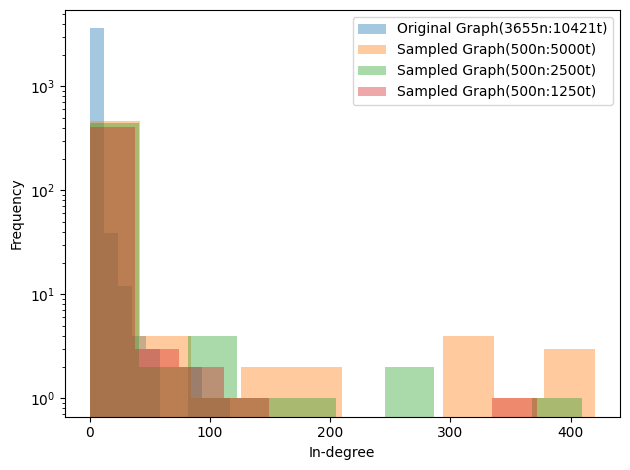

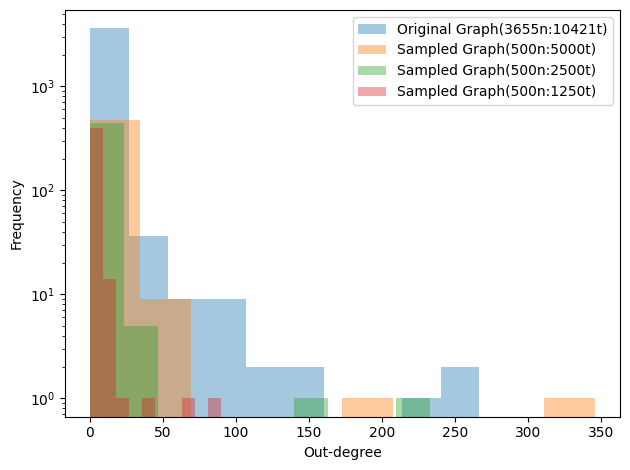

In [12]:
# Comparing impact of t' on in/out deg distributions
G_500n_5000t = pkl_to_graph('500nodes_5000traces')
G_500n_2500t = pkl_to_graph('500nodes_2500traces')
G_500n_1250t = pkl_to_graph('500nodes_1250traces')

Gs_and_labels = [[G_original, 'Original Graph(3655n:10421t)'],[G_500n_5000t, 'Sampled Graph(500n:5000t)'], \
                 [G_500n_2500t, 'Sampled Graph(500n:2500t)'], [G_500n_1250t, 'Sampled Graph(500n:1250t)']]

deg_dist_viz_hist(Gs_and_labels, 'in')
deg_dist_viz_hist(Gs_and_labels, 'out')

In [18]:
'''
Call depth percentage distribution
'''
def calc_graph_depth(G, initial_node):
    def dfs(node, visited, stack):
        # Using stack to avoid cycles
        if node in stack:
            return 0
        
        if node in visited:
            return visited[node]
        
        stack.add(node)
        max_depth = 0

        for neighbour in G.successors(node):
            depth = dfs(neighbour, visited, stack)
            max_depth = max(max_depth, depth)

        stack.remove(node)

        visited[node] = max_depth + 1
        
        return visited[node]
    
    visited = {}
    stack = set()

    return dfs(initial_node, visited, stack)
    
# T_original
T_details = pkl_to_dict('downsampled_graphs/trace_details_data.pkl')
cd_count_dict = {}
ctr = 0
check = 0
hi = 0
for tid, t_edges in T_original.items():
    hi += 1
    G = nx.DiGraph()
    G.add_edges_from(t_edges)
    for node, indegree in G.in_degree():
        if indegree == 0:
            ctr += 1
            initial_node = node
            break
    cycles = list(nx.simple_cycles(G))
    if len(cycles) > 0:
        check += 1 
    # trace_depth = calc_graph_depth(G, t_ini_node)
    # if trace_depth not in cd_count_dict:
    #     cd_count_dict[trace_depth] = 1
    # else:
    #     cd_count_dict[trace_depth] += 1
print(hi)
print(check)
print(ctr)



10421
9705
8027


In [10]:
no_inode_tid_rpcid = df_rpcid_analysis(df)

100%|██████████| 5982/5982 [01:30<00:00, 66.33it/s]


In [14]:
import json
def save_dict_as_json(traces_dict, file_name):
    with open(file_name + '.json', 'w') as json_file:
        json.dump(traces_dict, json_file, indent=4)

save_dict_as_json(no_inode_tid_rpcid, 'rpc_id.json')

In [ ]:
'''
Sfsl ratio
'''

In [ ]:
'''
Loss of Edges
Baseline: Original Graph
For a fixed n nodes, we get number of edges lost for
different t' values. X:t', Y:num of edges
'''

def calc_number_of_edges(Gs_list):
    '''
    Args: Gs_list=[[G, num traces], [],..]
    '''
    traces_count_list = [x[1] for x in Gs_list]
    edges_count_list = [x[0].number_of_edges() for x in Gs_list]
    plt.figure(figsize=(10, 6))
    plt.scatter(traces_count_list, edges_count_list, c='blue', marker='o')
    plt.title('Number of Edges vs Number of traces')
    plt.xlabel('Num Traces')
    plt.ylabel('Num Edges')
    plt.grid(True)
    plt.show()

Gs_list = [[G_sampled_500, 5000], \
                 [G_sampled_250, 5000]]
